<a href="https://colab.research.google.com/github/HoangHungLN/MachineLearning_Assigment/blob/main/Assignment2/notebooks/Assignment2_CEML2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
##Xử lý dữ liệu

#Import thư viện
import re, regex as re2, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import os
from scipy import sparse
from IPython.display import display
plt.style.use("seaborn-v0_8"); sns.set_palette("Set2")  #Định dạng bảng

os.makedirs("modules", exist_ok= True)
!wget https://raw.githubusercontent.com/HoangHungLN/MachineLearning_Assigment/refs/heads/main/Assignment2/modules/features_extractor.py -O modules/features_extractor.py
!wget https://raw.githubusercontent.com/HoangHungLN/MachineLearning_Assigment/refs/heads/main/Assignment2/modules/tfidf_glove.py -O modules/tfidf_glove.py
!wget https://raw.githubusercontent.com/HoangHungLN/MachineLearning_Assigment/refs/heads/main/Assignment2/modules/models.py -O modules/models.py

os.makedirs("features/tfidf_glove", exist_ok= True)
!wget https://github.com/HoangHungLN/MachineLearning_Assigment/raw/refs/heads/main/Assignment2/features/tfidf_glove/Xte_w2v.npy -O features/tfidf_glove/Xte_w2v.npy
!wget https://github.com/HoangHungLN/MachineLearning_Assigment/raw/refs/heads/main/Assignment2/features/tfidf_glove/Xtr_w2v.npy -O features/tfidf_glove/Xtr_w2v.npy
!wget https://github.com/HoangHungLN/MachineLearning_Assigment/raw/refs/heads/main/Assignment2/features/tfidf_glove/Xva_w2v.npy -O features/tfidf_glove/Xva_w2v.npy
#Tải dữ liệu bảng CSV từ github
dataset_url = "https://raw.githubusercontent.com/HoangHungLN/MachineLearning_Assigment/refs/heads/main/Assignment2/data/all_tickets_processed_improved_v3.csv"
raw_data = pd.read_csv(dataset_url)
raw_data = raw_data.replace({r'â€‰':'', r'\u2009':''}, regex=True)  #Làm sạch dữ liệu

#In thử 5 dòng đầu
raw_data.head(5)

--2025-10-09 16:58:24--  https://raw.githubusercontent.com/HoangHungLN/MachineLearning_Assigment/refs/heads/main/Assignment2/modules/features_extractor.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4814 (4.7K) [text/plain]
Saving to: ‘modules/features_extractor.py’

modules/features_ex 100%[===================>]   4.70K  --.-KB/s    in 0s      

2025-10-09 16:58:24 (39.4 MB/s) - ‘modules/features_extractor.py’ saved [4814/4814]

--2025-10-09 16:58:24--  https://raw.githubusercontent.com/HoangHungLN/MachineLearning_Assigment/refs/heads/main/Assignment2/modules/tfidf_glove.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubuserconte

,Document,Topic_group
0,connection with icon icon dear please setup ic...,Hardware
1,work experience user work experience user hi w...,Access
2,requesting for meeting requesting meeting hi p...,Hardware
3,reset passwords for external accounts re expir...,Access
4,mail verification warning hi has got attached ...,Miscellaneous


In [41]:
#Kiểm tra số lượng mẫu và thuộc tính gốc của dữ liệu
print ("Số lượng mẫu có trong dataset là:", raw_data.shape[0])
print ("Số lượng thuộc tính có trong dataset là:", raw_data.shape[1])

Số lượng mẫu có trong dataset là: 47837
Số lượng thuộc tính có trong dataset là: 2


Document       0
Topic_group    0
dtype: int64
Duplicates: 0
text_col: Document label_col: Topic_group


,count
Topic_group,
Hardware,13617
HR Support,10915
Access,7125
Miscellaneous,7060
Storage,2777


count    47837.000000
mean        43.597341
std         56.736800
min          2.000000
25%         17.000000
50%         26.000000
75%         46.000000
max        981.000000
Name: Document, dtype: float64


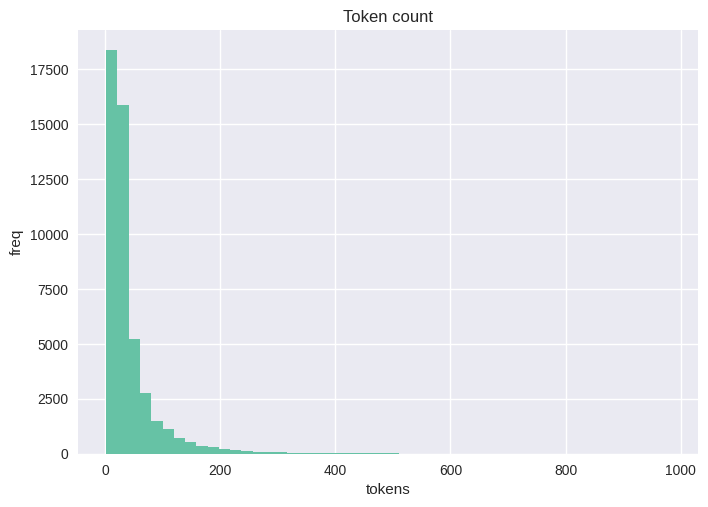

In [42]:
# Kiểm tra dữ liệu null và trùng lặp
print(raw_data.isna().sum().sort_values(ascending=False).head())
print("Duplicates:", raw_data.duplicated().sum())

# Xác định cột văn bản và cột nhãn
obj_cols = [c for c in raw_data.columns if raw_data[c].dtype=='object']
text_col = max(obj_cols, key=lambda c: raw_data[c].astype(str).str.len().mean())
label_col = [c for c in raw_data.columns if c != text_col][0]  # dataset có 2 cột

print("text_col:", text_col, "label_col:", label_col)

# Thống kê phân phối nhãn
vc = raw_data[label_col].value_counts()
display(vc.head()); (vc/vc.sum()).head()

# Thống kê độ dài văn bản
lens = raw_data[text_col].astype(str).str.split().map(len)
print(lens.describe())
plt.figure(); lens.hist(bins=50); plt.title('Token count'); plt.xlabel('tokens'); plt.ylabel('freq'); plt.show()

# Đề xuất max_len và vocab_limit
max_len = int(np.percentile(lens, 95))  # gợi ý
vocab_limit = 30000

**Nhận xét về dữ liệu**

*Tính sạch của dữ liệu*

- Không có giá trị bị thiếu (NaN).

- Không có dòng trùng lặp.

-> Dữ liệu gốc rất sạch, không cần xử lý thiếu/trùng.

*Cột dữ liệu*

- Document: cột chứa văn bản (mô tả sự cố IT).

- Topic_group: cột nhãn phân loại (loại sự cố).

*Phân phối nhãn*

- 5 nhóm chính:

- Hardware: 13,617 mẫu

- HR Support: 10,915 mẫu

- Access: 7,125 mẫu

- Miscellaneous: 7,060 mẫu

- Storage: 2,777 mẫu

-> Các nhãn hơi mất cân bằng: Hardware nhiều gấp gần 5 lần Storage.
Cần lưu ý khi huấn luyện mô hình (có thể dùng class weights).

*Độ dài văn bản*

- Trung bình: ~44 từ.

- Median (50% dữ liệu): 26 từ.

- 75% dữ liệu: ≤ 46 từ.

- Văn bản dài nhất: 981 từ.

-> Biểu đồ histogram cho thấy đa số văn bản rất ngắn (<50 từ), chỉ một số ít cực dài → phân phối lệch phải (skewed).

*Tham số tiền xử lý đề xuất*

- max_len = ~120 (percentile 95) -> đủ bao phủ 95% dữ liệu, tránh bị outlier kéo dài.

- vocab_limit = 30,000 -> giới hạn từ vựng cho tokenizer, cân bằng giữa hiệu quả và tài nguyên.

In [43]:
#Chia train 80%, test 10%, validation 10%
from sklearn.model_selection import train_test_split
train, test = train_test_split(raw_data, test_size=0.1, stratify=raw_data[label_col], random_state=42)
train, val  = train_test_split(train,    test_size=0.1, stratify=train[label_col],    random_state=42)

In [44]:
import re
import pandas as pd

# Gộp toàn bộ dữ liệu (nếu bạn có train / val / test)
all_text = pd.concat([train[text_col], val[text_col], test[text_col]], ignore_index=True)

# Regex: tìm ký tự KHÔNG phải chữ (A-Z a-z) và KHÔNG phải số (0-9)
pattern = re.compile(r"[^A-Za-z0-9]")

# Dòng nào chứa ký tự không phải chữ/số
mask = all_text.str.contains(pattern)

# Thống kê
count_special = mask.sum()
total = len(all_text)

print(f"Số dòng chứa ký tự không phải chữ/số: {count_special}/{total} ({count_special/total:.2%})")

# In vài ví dụ
print("\nVí dụ các dòng có ký tự không phải chữ/số:")
print(all_text[mask].sample(min(10, count_special), random_state=42).tolist())

Số dòng chứa ký tự không phải chữ/số: 47837/47837 (100.00%)

Ví dụ các dòng có ký tự không phải chữ/số:
['oracle task list malfunction task list malfunction hello task list does remove task when complete still appears have items review action upon same upper right hand corner thank you unit manager', 'outlook calendar issue calendar hi when click scheduling tab within meeting invite able anyone calendars know if available attend meetings can you please fix for going for over week please attached thank you advertising', 'please remove access for from please hi please best regards design lead', 'new project code request thursday november pm re code please thursday november pm code hi raised requested please let needs created well thank kind regards analyst ext hub thursday november pm code good morning please attached thanks officer', 'check if access to is still needed tuesday pm re devices hi apologies thought had replied remember looking approved requester how required duration disabl

In [45]:
#Import thư viện
!pip -q install emoji unidecode
import nltk; nltk.download('stopwords')
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sk_sw
from nltk.corpus import stopwords
from emoji import replace_emoji
from unidecode import unidecode
import unicodedata
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
std_english_stop = set(stopwords.words('english')) | set(sk_sw)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:

import numpy as np
from typing import List, Tuple, Dict, Any, Set
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

def mine_stopwords_topPct_coef(
    corpus: List[str],           # TRAIN texts (đã clean sơ bộ, CHƯA remove stopwords)
    y: np.ndarray,               # TRAIN labels
    *,
    ngram_range: Tuple[int,int]=(1,2),
    min_df: int|float=2,         # bỏ token quá hiếm khi vectorize
    top_pct: float=0.10,         # lấy Top-X% DF làm candidate (vd 0.10 = 10%)
    lowercase: bool=False,
    use_binary: bool=True,       # dùng X>0 cho LR để tránh thiên lệch do lặp
    class_weight: str|dict="balanced",
    max_iter: int=300,
    # chọn “gần 0” theo 1 trong 2 cách:
    mode: str="frac",            # 'frac' | 'eps'
    bottom_frac: float=0.05,     # nếu mode='frac': lấy bottom 5% theo |coef|
    eps: float=1e-2,             # nếu mode='eps' : chọn |coef| <= eps
    verbose: bool=True
) -> Dict[str, Any]:
    """
    1) Chọn Top-X% token theo DF làm candidate.
    2) Train LogisticRegression(class_weight='balanced') trên tập candidate.
    3) Lọc các token có |coef| ≈ 0 => stopwords domain.

    Trả về: {'stopwords', 'vocab', 'candidates', 'coef_abs', 'top_idx', 'df'}
    """
    # ----- Vectorize toàn bộ (để tính DF) -----
    vec = CountVectorizer(ngram_range=ngram_range, min_df=min_df,
                          lowercase=lowercase, stop_words=None)
    X = vec.fit_transform(corpus)                      # sparse [n_samples, n_features]
    vocab = vec.get_feature_names_out()
    n_docs = X.shape[0]
    df = (X > 0).sum(axis=0).A1

    # ----- Top-X% theo DF làm candidates -----
    m = len(vocab)
    k = max(1, int(top_pct * m))
    order = df.argsort()[::-1]                        # desc DF
    top_idx = order[:k]
    cand_vocab = vocab[top_idx]

    # ----- Ma trận cho LR -----
    Xc = X[:, top_idx]
    if use_binary:
        Xc = (Xc > 0).astype(int)                     # binary presence

    # ----- Train LR (balanced) -----
    clf = LogisticRegression(
        class_weight=class_weight,
        max_iter=max_iter,
        n_jobs=None if hasattr(LogisticRegression(), "n_jobs") else None
    )
    clf.fit(Xc, y)

    # Lấy |coef| (n_classes x k) -> trung bình theo lớp
    coef_abs = np.abs(clf.coef_).mean(axis=0)         # shape (k,)

    # ----- Chọn “gần 0” -----
    if mode == "frac":
        bw = max(1, int(bottom_frac * len(coef_abs))) # bottom k%
        weak_local_idx = np.argsort(coef_abs)[:bw]
        stopwords_auto = set(cand_vocab[weak_local_idx])
    elif mode == "eps":
        weak_local_idx = np.where(coef_abs <= eps)[0]
        stopwords_auto = set(cand_vocab[weak_local_idx])
    else:
        raise ValueError("mode phải là 'frac' hoặc 'eps'.")

    if verbose:
        print(f"[INFO] vocab={m:,}, X={X.shape}, nnz={X.nnz:,}")
        print(f"[INFO] candidates (Top {int(top_pct*100)}% DF) = {len(cand_vocab):,}")
        if mode == "frac":
            print(f"[INFO] stopwords (|coef| bottom {int(bottom_frac*100)}%) = {len(stopwords_auto):,}")
        else:
            print(f"[INFO] stopwords (|coef| <= {eps}) = {len(stopwords_auto):,}")
        # Ví dụ vài từ “gần 0”
        ex = sorted(list(stopwords_auto))[:30]
        print("[SAMPLE]", ex)

    return {
        "stopwords": stopwords_auto,
        "vocab": vocab,
        "candidates": cand_vocab,
        "coef_abs": coef_abs,     # |coef| tương ứng với cand_vocab
        "top_idx": top_idx,
        "df": df
    }

In [47]:
import re

def normalize_stopset(stopset):
    out = set()
    for t in stopset:
        if not isinstance(t, str):
            continue
        t = t.strip().lower()
        if not t:
            continue
        # tách theo khoảng trắng, chỉ giữ token chữ/số (đã clean lowercase từ trước)
        parts = re.findall(r"\w+", t)
        out.update(parts)
    return out

In [48]:
class TextPreprocessor:
    def __init__(self, lower=True, strip_accents=False,
                 remove_urls=True, remove_emojis=True,
                 remove_special=True, remove_numbers=False,
                 remove_stopwords=True, stopwords=None,
                 max_words=30000, max_len=128, oov_token='<OOV>'):
        # Thiết lập tham số tiền xử lý
        self.lower = lower
        self.strip_accents = strip_accents
        self.remove_urls = remove_urls
        self.remove_emojis = remove_emojis
        self.remove_special = remove_special
        self.remove_numbers = remove_numbers
        self.remove_stopwords = remove_stopwords
        # stopwords: set các token đã chuẩn hóa lowercase
        self.stop = set(stopwords) if stopwords else set()

        # Tokenizer để biến từ thành số
        self.tok = Tokenizer(num_words=max_words, oov_token=oov_token)
        self.max_len = max_len

    def _clean(self, s):
        # Làm sạch 1 câu văn bản
        if not isinstance(s, str):
            # ép kiểu an toàn nếu lỡ là bytes/number
            try:
                s = s.decode('utf-8', errors='ignore')
            except Exception:
                s = str(s)

        # Chuẩn hóa Unicode + loại một số zero-width phổ biến
        s = unicodedata.normalize('NFKC', s)
        s = s.replace('\u2009', '').replace('\u200b', '')

        if self.lower:
            s = s.lower()
        if self.strip_accents:
            s = unidecode(s)

        # URL / email / mention / hashtag (thay bằng khoảng trắng để tránh dính chữ)
        if self.remove_urls:
            s = re.sub(r'(https?://\S+|www\.\S+|[\w\.-]+@[\w\.-]+\.\w+|@\w+|#\w+)', ' ', s)

        # Emoji → xóa (hoặc thay bằng khoảng trắng)
        if self.remove_emojis:
            s = replace_emoji(s, replace=' ')

        # Loại ký tự đặc biệt, giữ chữ cái (cả tiếng Việt), số và khoảng trắng
        if self.remove_special:
            s = re2.sub(r"[^\p{L}\p{N}\s]", " ", s)

        # Loại số nếu cần
        if self.remove_numbers:
            s = re.sub(r"\d+(\.\d+)?", " ", s)

        # Tokenize đơn giản theo \w+ (UNIDODE) rồi remove stopwords nếu bật
        toks = re.findall(r"\w+", s, flags=re.UNICODE)
        if self.remove_stopwords and self.stop:
            toks = [t for t in toks if t not in self.stop]

        # Ghép lại & chuẩn hóa khoảng trắng
        return " ".join(toks).strip()

    def fit(self, texts):
        # Làm sạch + xây dựng từ điển từ train
        cleaned = [self._clean(t) for t in texts]
        self.tok.fit_on_texts(cleaned)
        return cleaned

    def transform(self, texts):
        # Làm sạch + chuyển văn bản thành số + padding
        cleaned = [self._clean(t) for t in texts]
        seq = self.tok.texts_to_sequences(cleaned)
        pad = pad_sequences(seq, maxlen=self.max_len, padding='post', truncating='post')
        return pad, cleaned

    def fit_transform(self, texts):
        # Kết hợp fit và transform cho tập train
        cleaned = self.fit(texts)
        seq = self.tok.texts_to_sequences(cleaned)
        pad = pad_sequences(seq, maxlen=self.max_len, padding='post', truncating='post')
        return pad, cleaned

In [49]:
# Khởi tạo bộ tiền xử lý với tham số đã chọn
tp_basic = TextPreprocessor(
    lower=True,
    strip_accents=False,
    remove_urls=True,
    remove_emojis=True,
    remove_special=True,
    remove_numbers=True,     # giữ lại số (mã lỗi, version có thể quan trọng)
    remove_stopwords=False,
    stopwords=None,
    max_words=vocab_limit,    # giới hạn từ vựng
    max_len=max_len           # chiều dài chuỗi sau padding
)

# Tiền xử lý văn bản -> chuyển thành chuỗi số đã padding
_,tr_cleaned = tp_basic.fit_transform(train[text_col].astype(str))   # fit trên train
_,va_cleaned = tp_basic.transform(val[text_col].astype(str))         # transform val
_, te_cleaned = tp_basic.transform(test[text_col].astype(str))        # transform test

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
ytr = le.fit_transform(train[label_col])
yva = le.transform(val[label_col])
yte = le.transform(test[label_col])
res = mine_stopwords_topPct_coef(
    corpus=tr_cleaned, y=ytr,
    ngram_range=(1,2),
    min_df=2,
    top_pct=0.005,
    lowercase=False,
    use_binary=True,
    class_weight="balanced",
    max_iter=300,
    mode="frac",         # lấy bottom theo tỉ lệ
    bottom_frac=0.02,    # bottom 5% |coef|
    verbose=True
)

DOMAIN_STOP_AUTO = normalize_stopset(res["stopwords"])
FINAL_STOPWORDS = (DOMAIN_STOP_AUTO) | std_english_stop

tp = TextPreprocessor(
    lower=True, strip_accents=False,
    remove_urls=True, remove_emojis=True,
    remove_special=True, remove_numbers=True,
    remove_stopwords=True,
    stopwords=FINAL_STOPWORDS
)
_, tr_clean = tp.fit_transform(train[text_col].astype(str))
_, va_clean = tp.transform(val[text_col].astype(str))
_, te_clean = tp.transform(test[text_col].astype(str))


[INFO] vocab=146,485, X=(38747, 146485), nnz=2,323,896
[INFO] candidates (Top 0% DF) = 732
[INFO] stopwords (|coef| bottom 2%) = 14
[SAMPLE] ['about', 'ask', 'dear', 'each subsidiaries', 'for', 'friday', 'march', 'new purchase', 'number whose', 'registered old', 'same', 'street kingdom', 'the', 'whose registered']


In [50]:
print("Số lượng stopwords domain:", len(DOMAIN_STOP_AUTO))
print("Một vài stopwords domain:", list(sorted(DOMAIN_STOP_AUTO))[:30])
print("Tổng Số lượng stopwords:", len(FINAL_STOPWORDS))
print("Một vài stopwords:", list(sorted(FINAL_STOPWORDS))[:30])

Số lượng stopwords domain: 18
Một vài stopwords domain: ['about', 'ask', 'dear', 'each', 'for', 'friday', 'kingdom', 'march', 'new', 'number', 'old', 'purchase', 'registered', 'same', 'street', 'subsidiaries', 'the', 'whose']
Tổng Số lượng stopwords: 409
Một vài stopwords: ['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'ain', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway']


In [51]:
s = train[text_col].iloc[0]         # lấy 1 văn bản gốc từ tập train
_, c = tp.transform([s])            # tiền xử lý văn bản
print("RAW:", s)                    # in ra bản gốc
print("CLEAN:", c[0])               # in ra bản đã làm sạch

RAW: stage is catalogue item removed sent friday stage catalogue item removed hello could you please have look stage set catalog item removed cannot be changed could you please amend we resolve request kind regards specialist
CLEAN: stage catalogue item removed sent stage catalogue item removed hello look stage set catalog item removed changed amend resolve request kind regards specialist


# **Features extraction (Trích xuất đặc trưng dữ liệu)**

Ở bước này, nhóm em lựa chọn ba phương pháp trích xuất đặc trưng chính để biểu diễn dữ liệu văn bản:  
1. **BoW (Bag of Words)**  
2. **TF–IDF (Term Frequency – Inverse Document Frequency)**  
3. **TF–IDF Weighted GloVe Embedding** – kết hợp giữa mô hình GloVe và trọng số TF–IDF.  

---

## **Các phương pháp trích xuất đặc trưng**

### BoW (Bag of Words)
Phương pháp BoW biểu diễn mỗi văn bản dưới dạng vector dựa trên **tần suất xuất hiện của từ** trong tập dữ liệu.  
Các từ trong toàn bộ tập văn bản được đưa vào một “từ điển”, và mỗi câu được biến thành một vector chứa số lần xuất hiện của từng từ trong từ điển đó.  
- **Ưu điểm:** Đơn giản, dễ triển khai.  
- **Nhược điểm:** Không nắm bắt được ngữ nghĩa hoặc thứ tự từ.  

**Cấu hình mặc định trong pipeline:**
- `max_features = 5000`  
- `ngram_range = (1, 2)` (sử dụng cả unigram và bigram)  
- `min_df = 2`, `max_df = 0.9` (loại bỏ từ quá hiếm hoặc quá phổ biến)  
- `lowercase = False` (vì dữ liệu đã được chuẩn hóa từ bước preprocessing)  

---

### TF–IDF (Term Frequency – Inverse Document Frequency)
Phương pháp TF–IDF mở rộng từ BoW, gán trọng số cho mỗi từ dựa trên **tần suất xuất hiện trong một văn bản (TF)** và **độ hiếm trong toàn bộ tập dữ liệu (IDF)**.  
Điều này giúp giảm ảnh hưởng của các từ phổ biến và làm nổi bật các từ mang thông tin đặc trưng hơn.  
- **Ưu điểm:** Giúp mô hình chú ý đến các từ quan trọng.  
- **Nhược điểm:** Vẫn chưa nắm bắt được ngữ nghĩa ngữ cảnh của từ.

**Cấu hình trong pipeline:**
- `max_features = 5000`  
- `ngram_range = (1, 2)`  
- `min_df = 2`, `max_df = 0.9`  
- `sublinear_tf = True` (giảm ảnh hưởng từ có tần suất quá cao)  
- `use_idf = True` (kích hoạt trọng số nghịch đảo IDF)  

---

### TF–IDF Weighted GloVe Embedding
Phương pháp này kết hợp giữa **mô hình nhúng từ GloVe** (Global Vectors for Word Representation) và **trọng số TF–IDF** để tạo biểu diễn câu có ý nghĩa ngữ nghĩa hơn.  

Cụ thể:
1. Mỗi từ trong văn bản được ánh xạ sang vector GloVe (kích thước 300 chiều).  
2. Trọng số TF–IDF được tính cho từng từ.  
3. Vector biểu diễn của câu được tính bằng trung bình có trọng số TF–IDF của các vector từ.


**Cấu hình trong pipeline:**
- Mô hình tiền huấn luyện: 2024 Wikipedia + Gigaword 5 (11.9B tokens, 1.2M vocab, uncased, 300d vectors, 1.6 GB download)[Tải tại đây](https://nlp-stanford-edu.translate.goog/data/wordvecs/glove.2024.wikigiga.300d.zip?_x_tr_sl=en&_x_tr_tl=vi&_x_tr_hl=vi&_x_tr_pto=tc)
- Kích thước vector: `300`  
- Tokenizer: tách từ bằng regex `\w+`  
- Vector câu: trung bình có trọng số TF–IDF  

**Ưu điểm:**  
- Giữ được thông tin ngữ nghĩa của GloVe.  
- Kết hợp được độ quan trọng thống kê của TF–IDF.  

**Chú ý**
- Quá trình tính TF–IDF Weighted GloVe mất nhiều thời gian (~15 phút/lần chạy), nên nhóm em tách phần xử lý này sang file `tfidf_glove.py` và chỉ sử dụng các file đặc trưng `.npy` được trích xuất sẵn từ đợt huấn luyện trong lúc làm bài và lưu trong github nhóm để huấn luyện mô hình.

---

## **Tổng kết**

- Hai phương pháp trích xuất đặc trưng cổ điển **BoW** và **TF–IDF** được triển khai trong file `features_extractor.py`.  
  Các ma trận đặc trưng của hai phương pháp này được lưu dưới dạng file `.npz` để phục vụ cho quá trình huấn luyện và đánh giá mô hình.  
  Hàm `report_vectorizer()` được sử dụng để in ra các thông số cấu hình và thống kê như số chiều đặc trưng, độ thưa (density) và kích thước từ vựng của từng phương pháp.  

- Phương pháp **TF–IDF Weighted GloVe Embedding** được triển khai riêng trong file `tfidf_glove.py`.  
- Do quá trình trích xuất đặc trưng này kết hợp giữa mô hình GloVe kích thước 300 chiều và trọng số TF–IDF nên mất nhiều thời gian xử lý (khoảng 10–15 phút). Vì vậy, nhóm em chỉ thực hiện tính toán một lần duy nhất, sau đó lưu kết quả đặc trưng ra file `.npy` để sử dụng làm đầu vào cho các mô hình huấn luyện sau này.
## **Về `tfidf_glove.py`**

- **Phiên bản thư viện**
  - `scipy == 1.12.*`
  - `gensim == 4.3.2`

- **Bộ vector từ**
  - `glove.2024.wikigiga.300d.zip` tải từ: https://nlp.stanford.edu/data/wordvecs/glove.2024.wikigiga.300d.zip
  - Sử dụng tệp 300 chiều sau khi giải nén; chuyển sang định dạng Word2Vec bằng `glove2word2vec`.

- **Ghi chú triển khai**
  - Tokenization đơn giản theo `\w+` trên văn bản đã được làm sạch.
  - Fit `TfidfVectorizer` trên **train** để lấy IDF; câu vector = trung bình có trọng số **TF × IDF** của các word vectors GloVe.
  - Kết quả đặc trưng được lưu dạng `.npy` tại `features/tfidf_glove/` (train/val/test).

- **Lệnh cài đặt nhanh trong Colab**
  ```bash
  !pip install "scipy==1.12.*" gensim==4.3.2
  !wget "https://nlp.stanford.edu/data/wordvecs/glove.2024.wikigiga.300d.zip"
  !unzip -q glove.2024.wikigiga.300d.zip -d glove.2024.300d

In [52]:
from modules.features_extractor import *
sum_bow = features_extractor_classic(
    tr_clean, va_clean, te_clean,
    mode="BoW",
    max_features=20000,
    ngram_range=(1,2),
    min_df=2,
    max_df=0.9,
)

Xtr_bow = sparse.load_npz("features/bow/Xtr.npz")
Xva_bow = sparse.load_npz("features/bow/Xva.npz")
Xte_bow = sparse.load_npz("features/bow/Xte.npz")
print(sum_bow)

sum_tfidf = features_extractor_classic(
    tr_clean, va_clean, te_clean,
    mode="TFIDF",
    max_features=20000,
    ngram_range=(1,2),
    min_df=2,
    max_df=0.9,
)
Xtr_tfidf = sparse.load_npz("features/tfidf/Xtr.npz")
Xva_tfidf = sparse.load_npz("features/tfidf/Xva.npz")
Xte_tfidf = sparse.load_npz("features/tfidf/Xte.npz")
print(sum_tfidf)

Bag-of-Words Report

>>> Vectorizer params:
  - type: CountVectorizer
  - ngram_range: (1, 2)
  - min_df: 2
  - max_df: 0.9
  - max_features: 20000
  - lowercase: False
  - token_pattern: (?u)\b\w\w+\b
  - use_idf: None
  - sublinear_tf: None
  - stop_words: None
  - vocab_size: 20000

>>> Matrix stats:
  [Train] shape=(38747, 20000)  nnz=1,398,193  density=0.001804
  [Val] shape=(4306, 20000)  nnz=154,848  density=0.001798
  [Test] shape=(4784, 20000)  nnz=171,846  density=0.001796
TF-IDF Report

>>> Vectorizer params:
  - type: TfidfVectorizer
  - ngram_range: (1, 2)
  - min_df: 2
  - max_df: 0.9
  - max_features: 20000
  - lowercase: False
  - token_pattern: (?u)\b\w\w+\b
  - use_idf: True
  - sublinear_tf: True
  - stop_words: None
  - vocab_size: 20000

>>> Matrix stats:
  [Train] shape=(38747, 20000)  nnz=1,398,193  density=0.001804
  [Val] shape=(4306, 20000)  nnz=154,848  density=0.001798
  [Test] shape=(4784, 20000)  nnz=171,846  density=0.001796


In [53]:
Xtr_w2v = np.load("features/tfidf_glove/Xtr_w2v.npy")
Xva_w2v = np.load("features/tfidf_glove/Xva_w2v.npy")
Xte_w2v = np.load("features/tfidf_glove/Xte_w2v.npy")

#Tìm mô hình tối ưu
Chạy các mô hình Naive Bayes, SVM, Logistic Regression với 3 bộ tham số khác nhau cho mỗi mô hình và với 3 loại embedding (BoW, TF-IDF, GloVe).

Cài đặt bộ tham số cần đánh giá cho từng mô hình.

In [54]:
model_params = {
    'NaiveBayes': [
        {'alpha': 0.1},
        {'alpha': 1.0},
        {'alpha': 0.5}
    ],
    'LogisticRegression': [
        {'C': 0.1, 'max_iter': 1000},
        {'C': 1.0, 'max_iter': 1000},
        {'C': 10.0, 'max_iter': 1000}
    ],
    'SVM': [
        {'C': 0.1},
        {'C': 1.0}
        #{'C': 10.0}
        #Nhóm đã thử với C = 10.0 tuy nhiên độ chính xác của mô hình không tăng
        #Nhận thấy SVM chạy rất tốn thời gian nên nhóm đã bỏ ra khỏi mô hình để tránh quá mất thời gian.
    ]
}

In [82]:
import inspect

# Get the source code of the functions
run_models_source = inspect.getsource(run_models)
evaluate_model_on_test_source = inspect.getsource(evaluate_model_on_test)

# Combine the source code
models_module_content = run_models_source + "\n" + evaluate_model_on_test_source

# Write the content to the file
with open("modules/models.py", "w") as f:
    f.write(models_module_content)

print("Functions written to modules/models.py")

Functions written to modules/models.py


In [104]:
from modules.models import run_models, evaluate_model_on_test
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.svm import LinearSVC
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import classification_report, accuracy_score

## Đánh giá Naive Bayes
Nhóm sử dụng mô hình MultinomialNB - Biến thể Naive Bayes dùng cho đặc trưng là tần suất(tần suất xuất hiện của từ), mô hình hoàn toàn phù hợp với vector đặc trưng được trích xuất từ BoW và TF-IDF

Chỉ chạy Naive Bayes với 2 cách trích xuất đặc trưng là BoW và TF-IDF vì Naive Bayes không thể xử lý được giá trị âm từ đặc trưng được trích xuất từ TF-IDF GloVe.

In [105]:
# --- Đánh giá Naive Bayes ---
nb_params_list = model_params['NaiveBayes']
best_nb_bow_params = None
best_nb_bow_accuracy = -1
best_nb_tfidf_params = None
best_nb_tfidf_accuracy = -1

nb_bow_results = {}
nb_tfidf_results = {}

# Naive Bayes with BoW features
print("\n--- Running Naive Bayes on BoW features ---")
for params in nb_params_list:
    print(f"\nRunning with parameters: {params}")
    results = run_models(Xtr_bow, ytr, Xva_bow, yva, Xte_bow, yte, {'NaiveBayes': params})
    val_acc = results['NaiveBayes']['val_accuracy']
    nb_bow_results[str(params)] = {'val_accuracy': val_acc} # Store with string key for display

    if val_acc > best_nb_bow_accuracy:
        best_nb_bow_accuracy = val_acc
        best_nb_bow_params = params
        best_nb_bow_model = results['NaiveBayes']['model']

# Naive Bayes with TF-IDF features
print("\n--- Running Naive Bayes on TF-IDF features ---")
for params in nb_params_list:
    print(f"\nRunning with parameters: {params}")
    results = run_models(Xtr_tfidf, ytr, Xva_tfidf, yva, Xte_tfidf, yte, {'NaiveBayes': params})
    val_acc = results['NaiveBayes']['val_accuracy']
    nb_tfidf_results[str(params)] = {'val_accuracy': val_acc} # Store with string key for display

    if val_acc > best_nb_tfidf_accuracy:
        best_nb_tfidf_accuracy = val_acc
        best_nb_tfidf_params = params
        best_nb_tfidf_model = results['NaiveBayes']['model']

# Evaluate the best models on the test set
print("\n--- Mô hình NB với tham số tốt nhất trong các mô hình đã kiểm tra ---")
if best_nb_bow_model:
    best_nb_bow_test_accuracy = evaluate_model_on_test(best_nb_bow_model, Xte_bow, yte, f"Naive Bayes (BoW) Best Params: {best_nb_bow_params}")
    nb_bow_results[str(best_nb_bow_params)]['test_accuracy'] = best_nb_bow_test_accuracy
if best_nb_tfidf_model:
    best_nb_tfidf_test_accuracy = evaluate_model_on_test(best_nb_tfidf_model, Xte_tfidf, yte, f"Naive Bayes (TF-IDF) Best Params: {best_nb_tfidf_params}")
    nb_tfidf_results[str(best_nb_tfidf_params)]['test_accuracy'] = best_nb_tfidf_test_accuracy

# Store results for later overall comparison
results_nb = {
    'BoW': nb_bow_results,
    'TF-IDF': nb_tfidf_results
}


--- Running Naive Bayes on BoW features ---

Running with parameters: {'alpha': 0.1}
Validation Accuracy: 0.77914537854157

Running with parameters: {'alpha': 1.0}
Validation Accuracy: 0.783790060380864

Running with parameters: {'alpha': 0.5}
Validation Accuracy: 0.7777519739897817

--- Running Naive Bayes on TF-IDF features ---

Running with parameters: {'alpha': 0.1}
Validation Accuracy: 0.8014398513701811

Running with parameters: {'alpha': 1.0}
Validation Accuracy: 0.7756618671620994

Running with parameters: {'alpha': 0.5}
Validation Accuracy: 0.7928471899674873

--- Mô hình NB với tham số tốt nhất trong các mô hình đã kiểm tra ---

--- Đánh giá mô hình Naive Bayes (BoW) Best Params: {'alpha': 1.0} tốt nhất trên tập Test ---
Test Accuracy: 0.7897157190635451
              precision    recall  f1-score   support

           0       0.77      0.86      0.81       712
           1       0.69      0.73      0.71       176
           2       0.91      0.69      0.79      1092
       

## Nhận xét Naive Bayes
### Tổng quan mô hình
Mô hình Naive Bayes đạt độ chính xác khoảng 79-80% trên tập kiểm thử, cho thấy khả năng phân loại khá tốt với dữ liệu văn bản đa lớp. Tuy nhiên, vì NB giả định các đặc trưng độc lập - điều này không hoàn toàn đúng trong ngữ cảnh ngôn ngữ nên độ chính xác này vẫn chưa phải tối ưu nhất(các mô hình khác có thể có độ chính xác cao hơn).

Giá trị recall, precision, f1-score giữa các nhóm không đều tuy nhiên macro avg khoảng 0.79 chứng tỏ mô hình không quá lệch về các lớp có nhiều dữ liệu.

### Tham số tốt nhất
Nhóm sử dụng Accuracy trên tập validation để đánh giá xem với siêu tham số nào sẽ phù hợp nhất với mô hình Naive Bayes trên từng cách trích xuất đặc trưng khác nhau.

Dựa vào kết quả, nhận thấy được với BoW thì tham số tốt hơn cho mô hình là alpha = 1, tuy nhiên với TF-IDF thì tham số alpha tốt hơn lại là 0.1

Điều này là do BoW tạo ra đặc trưng thô, có thể có nhiều từ có count = 0. Tham số alpha = 1 giúp làm trơn mạnh tránh xác suất = 0 nên giúp mô hình đạt độ chính xác cao hơn. Còn đối với TF-IDF thì đặc trưng đã được chuẩn hóa theo trọng số, nên các xác suất không còn cực đoan như trong BoW nữa, dẫn đến không cần phải làm mượt quá nhiều từ tham số alpha.

## Đánh giá Logistic Regression

In [106]:
# --- Đánh giá Logistic Regression ---
lr_params_list = model_params['LogisticRegression']
best_lr_bow_params = None
best_lr_bow_accuracy = -1
best_lr_tfidf_params = None
best_lr_tfidf_accuracy = -1
best_lr_glove_params = None
best_lr_glove_accuracy = -1

lr_bow_results = {}
lr_tfidf_results = {}
lr_glove_results = {}

# Logistic Regression with BoW features
print("\n--- Running Logistic Regression on BoW features ---")
for params in lr_params_list:
    print(f"\nRunning with parameters: {params}")
    results = run_models(Xtr_bow, ytr, Xva_bow, yva, Xte_bow, yte, {'LogisticRegression': params})
    val_acc = results['LogisticRegression']['val_accuracy']
    lr_bow_results[str(params)] = {'val_accuracy': val_acc} # Store with string key for display

    if val_acc > best_lr_bow_accuracy:
        best_lr_bow_accuracy = val_acc
        best_lr_bow_params = params
        best_lr_bow_model = results['LogisticRegression']['model']

# Logistic Regression with TF-IDF features
print("\n--- Running Logistic Regression on TF-IDF features ---")
for params in lr_params_list:
    print(f"\nRunning with parameters: {params}")
    results = run_models(Xtr_tfidf, ytr, Xva_tfidf, yva, Xte_tfidf, yte, {'LogisticRegression': params})
    val_acc = results['LogisticRegression']['val_accuracy']
    lr_tfidf_results[str(params)] = {'val_accuracy': val_acc} # Store with string key for display

    if val_acc > best_lr_tfidf_accuracy:
        best_lr_tfidf_accuracy = val_acc
        best_lr_tfidf_params = params
        best_lr_tfidf_model = results['LogisticRegression']['model']

# Logistic Regression with GloVe features
print("\n--- Running Logistic Regression on GloVe features ---")
for params in lr_params_list:
    print(f"\nRunning with parameters: {params}")
    results = run_models(Xtr_w2v, ytr, Xva_w2v, yva, Xte_w2v, yte, {'LogisticRegression': params})
    val_acc = results['LogisticRegression']['val_accuracy']
    lr_glove_results[str(params)] = {'val_accuracy': val_acc} # Store with string key for display

    if val_acc > best_lr_glove_accuracy:
        best_lr_glove_accuracy = val_acc
        best_lr_glove_params = params
        best_lr_glove_model = results['LogisticRegression']['model']

# Evaluate the best models on the test set
print("\n--- Evaluating Best Logistic Regression Models on Test Set ---")
if best_lr_bow_model:
    best_lr_bow_test_accuracy = evaluate_model_on_test(best_lr_bow_model, Xte_bow, yte, f"Logistic Regression (BoW) Best Params: {best_lr_bow_params}")
    lr_bow_results[str(best_lr_bow_params)]['test_accuracy'] = best_lr_bow_test_accuracy
if best_lr_tfidf_model:
    best_lr_tfidf_test_accuracy = evaluate_model_on_test(best_lr_tfidf_model, Xte_tfidf, yte, f"Logistic Regression (TF-IDF) Best Params: {best_lr_tfidf_params}")
    lr_tfidf_results[str(best_lr_tfidf_params)]['test_accuracy'] = best_lr_tfidf_test_accuracy
if best_lr_glove_model:
    best_lr_glove_test_accuracy = evaluate_model_on_test(best_lr_glove_model, Xte_w2v, yte, f"Logistic Regression (GloVe) Best Params: {best_lr_glove_params}")
    lr_glove_results[str(best_lr_glove_params)]['test_accuracy'] = best_lr_glove_test_accuracy

# Store results for later overall comparison
results_lr = {
    'BoW': lr_bow_results,
    'TF-IDF': lr_tfidf_results,
    'GloVe': lr_glove_results
}


--- Running Logistic Regression on BoW features ---

Running with parameters: {'C': 0.1, 'max_iter': 1000}
Validation Accuracy: 0.8555503947979564

Running with parameters: {'C': 1.0, 'max_iter': 1000}
Validation Accuracy: 0.8518346493265211

Running with parameters: {'C': 10.0, 'max_iter': 1000}
Validation Accuracy: 0.8432419879238272

--- Running Logistic Regression on TF-IDF features ---

Running with parameters: {'C': 0.1, 'max_iter': 1000}
Validation Accuracy: 0.7974918718067813

Running with parameters: {'C': 1.0, 'max_iter': 1000}
Validation Accuracy: 0.8543892243381328

Running with parameters: {'C': 10.0, 'max_iter': 1000}
Validation Accuracy: 0.8539247561542035

--- Running Logistic Regression on GloVe features ---

Running with parameters: {'C': 0.1, 'max_iter': 1000}
Validation Accuracy: 0.7552252670692058

Running with parameters: {'C': 1.0, 'max_iter': 1000}
Validation Accuracy: 0.774500696702276

Running with parameters: {'C': 10.0, 'max_iter': 1000}
Validation Accuracy

## Nhận xét Logistic Regression
### Tổng quan mô hình
Accuracy khoảng 85-87% cho BoW và TF-IDF là rất tốt, tuy nhiên với GloVe thì độ chính xác lại giảm đáng kể(khoảng 78%).
Accuracy ≈ 0.86. LR hoạt động tốt với không gian đặc trưng thưa, có chiều cao như BoW và TF-IDF

Với BoW và TF-IDF thì Precision/Recall/F1 đều cao (0.83-0.92) trên các lớp chính (0,2,3,5,6). Một số lớp nhỏ (1, 4, 7) có recall thấp hơn (0.6-0.8) do ít mẫu hoặc chồng chéo đặc trưng. Nhưng macro avg ≈ 0.85-0.87 là rất cân bằng mô hình học được các lớp chính và không quá lệch.

Đối với GloVe: Độ chính xác giảm rõ rệt do ảnh hưởng của trung bình vector. Vì là một mô hình tuyến tính, có thể không tận dụng được đầy đủ các mối quan hệ ngữ nghĩa phi tuyến tính, phức tạp được nắm bắt bởi các embedding từ đặc như GloVe. Từ đó ta thấy Logistic Regression không phù hợp với phương pháp trích xuất đặc trưng GloVe.
### Tham số tốt nhất

Nhóm sử dụng Accuracy trên tập validation để đánh giá xem với siêu tham số nào sẽ phù hợp nhất với mô hình Logistic Regression trên từng cách trích xuất đặc trưng khác nhau.

Dựa vào kết quả, nhận thấy được với BoW thì tham số tốt hơn cho mô hình là C = 0.1, TF-IDF = 1 và GloVe là 10.0.

Tham số 'C' kiểm soát nghịch đảo của độ mạnh điều chỉnh (regularization strength). C nhỏ hơn có nghĩa là điều chỉnh mạnh hơn giúp ngăn chặn overfitting.

Với BoW, đặc trưng là tần suất xuất hiện của từ dẫn dễ làm mô hình overfit lên từ phổ biến. Do đó ta cần điều chỉnh mạnh nên C = 0.1 là tối ưu.
Với TF-IDF, vốn đã giảm trọng số các thuật ngữ phổ biến nên ít cần điều chỉnh hơn, C lớn hơn một tí(C = 1). Điều này cho thấy việc gán trọng số TF-IDF làm cho các đặc trưng quan trọng nổi bật và điều chỉnh mạnh có thể gây phản tác dụng.

Với GloVe thì Logistic Regression cần regularization yếu hơn (C lớn) để tận dụng tối đa thông tin nhỏ trong vector. Tuy nhiên do tính chất của mô hình không phù hợp nên độ chính xác vẫn rất thấp.

In [107]:
# --- Đánh giá SVM ---
svm_params_list = model_params['SVM']
best_svm_bow_params = None
best_svm_bow_accuracy = -1
best_svm_tfidf_params = None
best_svm_tfidf_accuracy = -1
best_svm_glove_params = None
best_svm_glove_accuracy = -1

svm_bow_results = {}
svm_tfidf_results = {}
svm_glove_results = {}

# SVM with BoW features
print("\n--- Running SVM on BoW features ---")
for params in svm_params_list:
    print(f"\nRunning with parameters: {params}")
    results = run_models(Xtr_bow, ytr, Xva_bow, yva, Xte_bow, yte, {'SVM': params})
    val_acc = results['SVM']['val_accuracy']
    svm_bow_results[str(params)] = {'val_accuracy': val_acc} # Store with string key for display

    if val_acc > best_svm_bow_accuracy:
        best_svm_bow_accuracy = val_acc
        best_svm_bow_params = params
        best_svm_bow_model = results['SVM']['model']

# SVM with TF-IDF features
print("\n--- Running SVM on TF-IDF features ---")
for params in svm_params_list:
    print(f"\nRunning with parameters: {params}")
    results = run_models(Xtr_tfidf, ytr, Xva_tfidf, yva, Xte_tfidf, yte, {'SVM': params})
    val_acc = results['SVM']['val_accuracy']
    svm_tfidf_results[str(params)] = {'val_accuracy': val_acc} # Store with string key for display

    if val_acc > best_svm_tfidf_accuracy:
        best_svm_tfidf_accuracy = val_acc
        best_svm_tfidf_params = params
        best_svm_tfidf_model = results['SVM']['model']

# SVM with GloVe features
print("\n--- Running SVM on GloVe features ---")
for params in svm_params_list:
    print(f"\nRunning with parameters: {params}")
    results = run_models(Xtr_w2v, ytr, Xva_w2v, yva, Xte_w2v, yte, {'SVM': params})
    val_acc = results['SVM']['val_accuracy']
    svm_glove_results[str(params)] = {'val_accuracy': val_acc} # Store with string key for display

    if val_acc > best_svm_glove_accuracy:
        best_svm_glove_accuracy = val_acc
        best_svm_glove_params = params
        best_svm_glove_model = results['SVM']['model']

# Evaluate the best models on the test set
print("\n--- Evaluating Best SVM Models on Test Set ---")
if best_svm_bow_model:
    best_svm_bow_test_accuracy = evaluate_model_on_test(best_svm_bow_model, Xte_bow, yte, f"SVM (BoW) Best Params: {best_svm_bow_params}")
    svm_bow_results[str(best_svm_bow_params)]['test_accuracy'] = best_svm_bow_test_accuracy
if best_svm_tfidf_model:
    best_svm_tfidf_test_accuracy = evaluate_model_on_test(best_svm_tfidf_model, Xte_tfidf, yte, f"SVM (TF-IDF) Best Params: {best_svm_tfidf_params}")
    svm_tfidf_results[str(best_svm_tfidf_params)]['test_accuracy'] = best_svm_tfidf_test_accuracy
if best_svm_glove_model:
    best_svm_glove_test_accuracy = evaluate_model_on_test(best_svm_glove_model, Xte_w2v, yte, f"SVM (GloVe) Best Params: {best_svm_glove_params}")
    svm_glove_results[str(best_svm_glove_params)]['test_accuracy'] = best_svm_glove_test_accuracy

# Store results for later overall comparison
results_svm = {
    'BoW': svm_bow_results,
    'TF-IDF': svm_tfidf_results,
    'GloVe': svm_glove_results
}


--- Running SVM on BoW features ---

Running with parameters: {'C': 0.1}


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Validation Accuracy: 0.8453320947515095

Running with parameters: {'C': 1.0}


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Validation Accuracy: 0.8316302833255922

--- Running SVM on TF-IDF features ---

Running with parameters: {'C': 0.1}
Validation Accuracy: 0.8539247561542035

Running with parameters: {'C': 1.0}
Validation Accuracy: 0.8520668834184858

--- Running SVM on GloVe features ---

Running with parameters: {'C': 0.1}


KeyboardInterrupt: 

In [ ]:
# Phân tích cho SVM trên tất cả các bộ đặc trưng và tham số

print("Phân tích Mô hình SVM (Tham số Tốt nhất):")
print("--------------------------------------")

print("\nTóm tắt Kết quả (Tham số Tốt nhất):")
print("----------------------------------")

for feature_set, c_values in svm_results.items():
    print(f"\nBộ đặc trưng: {feature_set}")
    best_c = list(c_values.keys())[0]
    metrics = c_values[best_c]
    print(f"  Tham số tốt nhất (C) = {best_c}:")
    print(f"  Độ chính xác Validation: {metrics['val_accuracy']:.4f}")
    print(f"  Độ chính xác Test: {metrics['test_accuracy']:.4f}")

print("\nGiải thích Kết quả:")
print("-------------------")
print("Linear SVM (LinearSVC) là một bộ phân loại tuyến tính mạnh mẽ, tìm một siêu phẳng để phân tách các lớp với margin lớn nhất. Nó nổi tiếng là hoạt động tốt với dữ liệu thưa có chiều cao như BoW và TF-IDF.")
print("Tham số 'C' là tham số điều chỉnh. C nhỏ hơn có nghĩa là điều chỉnh mạnh hơn, phạt kích thước margin để giảm overfitting. C lớn hơn có nghĩa là điều chỉnh yếu hơn, cho phép margin nhỏ hơn để phù hợp hơn với dữ liệu huấn luyện.")
print("Đối với BoW và TF-IDF, điều chỉnh mạnh hơn (C nhỏ hơn) nhìn chung hoạt động tốt hơn, điều này phổ biến trong không gian chiều cao để ngăn mô hình trở nên quá phức tạp và overfitting.")
print("Các cảnh báo hội tụ cho thấy quá trình tối ưu hóa cho LinearSVC có thể chưa đạt đến cực tiểu toàn cục trong số lần lặp mặc định. Tăng `max_iter` có thể dẫn đến kết quả tốt hơn một chút, đặc biệt đối với các giá trị C cao hơn, nơi ít điều chỉnh hơn cho phép các mô hình phức tạp hơn.")
print("Hiệu suất thấp hơn với GloVe embeddings, tương tự Logistic Regression, chỉ ra rằng một SVM tuyến tính có thể không phải là mô hình tốt nhất để tận dụng đầy đủ các mối quan hệ phi tuyến tính và thông tin ngữ nghĩa phong phú được nhúng trong các vector từ đặc.")
print("Một lần nữa, cách tiếp cận lấy trung bình được sử dụng cho vector câu với GloVe có thể góp phần làm giảm hiệu suất so với các phương pháp xem xét thứ tự từ hoặc ngữ cảnh rõ ràng hơn.")

print("\nƯu điểm và Hạn chế của SVM cho Phân loại Văn bản:")
print("-------------------------------------------------")
print("Ưu điểm:")
print("- Hiệu quả trong không gian chiều cao (như BoW/TF-IDF).")
print("- Tìm siêu phẳng phân tách tối ưu, thường dẫn đến khả năng tổng quát hóa tốt.")
print("- Ít bị kẹt ở cực tiểu cục bộ hơn so với một số phương pháp tối ưu hóa khác.")
print("Hạn chế:")
print("- Có thể tốn kém tính toán cho các tập dữ liệu lớn (mặc dù LinearSVC có khả năng mở rộng tốt hơn kernel SVMs).")
print("- Hiệu suất có thể nhạy cảm với việc lựa chọn kernel và siêu tham số (như C).")
print("- Khó diễn giải hơn so với các mô hình như Naive Bayes hoặc Logistic Regression.")
print("- Linear SVM có thể không hoạt động tối ưu với các biểu diễn đặc trưng đặc, phức tạp như GloVe embeddings.")
print("- Các vấn đề hội tụ đôi khi có thể xảy ra, yêu cầu điều chỉnh tham số (ví dụ: max_iter).")

In [ ]:
# --- Overall Model and Embedding Comparison ---

print("====================================================")
print(" Overall Model and Embedding Comparison and Analysis")
print("====================================================")

print("\nSummary of Best Test Accuracies:")
print("--------------------------------")

# Extracting the best test accuracies for each model-embedding combination
best_accuracies = {
    'NaiveBayes': {
        'BoW': results_nb['BoW'][str(best_nb_bow_params)]['test_accuracy'] if best_nb_bow_params else None,
        'TF-IDF': results_nb['TF-IDF'][str(best_nb_tfidf_params)]['test_accuracy'] if best_nb_tfidf_params else None,
        'GloVe': None # Naive Bayes not suitable for dense GloVe
    },
    'LogisticRegression': {
        'BoW': results_lr['BoW'][str(best_lr_bow_params)]['test_accuracy'] if best_lr_bow_params else None,
        'TF-IDF': results_lr['TF-IDF'][str(best_lr_tfidf_params)]['test_accuracy'] if best_lr_tfidf_params else None,
        'GloVe': results_lr['GloVe'][str(best_lr_glove_params)]['test_accuracy'] if best_lr_glove_params else None
    },
    'SVM': {
        'BoW': results_svm['BoW'][str(best_svm_bow_params)]['test_accuracy'] if best_svm_bow_params else None,
        'TF-IDF': results_svm['TF-IDF'][str(best_svm_tfidf_params)]['test_accuracy'] if best_svm_tfidf_params else None,
        'GloVe': results_svm['GloVe'][str(best_svm_glove_params)]['test_accuracy'] if best_svm_glove_params else None
    }
}

print("Model              | BoW      | TF-IDF   | GloVe")
print("-------------------|----------|----------|-------")
for model, embeddings in best_accuracies.items():
    bow_acc = f"{embeddings['BoW']:.4f}" if embeddings['BoW'] is not None else 'N/A'
    tfidf_acc = f"{embeddings['TF-IDF']:.4f}" if embeddings['TF-IDF'] is not None else 'N/A'
    glove_acc = f"{embeddings['GloVe']:.4f}" if embeddings['GloVe'] is not None else 'N/A'
    print(f"{model:<18} | {bow_acc}   | {tfidf_acc}   | {glove_acc}")

print("\nAnalysis of Model Effectiveness:")
print("------------------------------")
print(f"- **Logistic Regression:** Achieved the highest overall accuracy with BoW features (~{best_accuracies['LogisticRegression']['BoW']:.4f if best_accuracies['LogisticRegression']['BoW'] is not None else 'N/A'}). It performed well with TF-IDF as well (~{best_accuracies['LogisticRegression']['TF-IDF']:.4f if best_accuracies['LogisticRegression']['TF-IDF'] is not None else 'N/A'}). Performance dropped significantly with GloVe (~{best_accuracies['LogisticRegression']['GloVe']:.4f if best_accuracies['LogisticRegression']['GloVe'] is not None else 'N/A'}). This suggests LR is highly effective with sparse, high-dimensional count/frequency-based features on this task.")
print(f"- **SVM (LinearSVC):** Performed very competitively with Logistic Regression, achieving its best accuracy with TF-IDF (~{best_accuracies['SVM']['TF-IDF']:.4f if best_accuracies['SVM']['TF-IDF'] is not None else 'N/A'}) and a similar score with BoW (~{best_accuracies['SVM']['BoW']:.4f if best_accuracies['SVM']['BoW'] is not None else 'N/A'}). Like LR, its performance was much lower with GloVe (~{best_accuracies['SVM']['GloVe']:.4f if best_accuracies['SVM']['GloVe'] is not None else 'N/A'}). SVM is also well-suited for high-dimensional sparse data but didn't surpass LR significantly in peak performance on this dataset and with the tested parameters.")
print(f"- **Naive Bayes (MultinomialNB):** Served as a good baseline, performing reasonably well with BoW (~{best_accuracies['NaiveBayes']['BoW']:.4f if best_accuracies['NaiveBayes']['BoW'] is not None else 'N/A'}) and slightly better with TF-IDF (~{best_accuracies['NaiveBayes']['TF-IDF']:.4f if best_accuracies['NaiveBayes']['TF-IDF'] is not None else 'N/A'}). It cannot be used with dense GloVe embeddings. While simpler and faster, its performance is noticeably lower than LR and SVM, likely due to its strong assumption of feature independence.")
print("\nBased on the results, **Logistic Regression** or **Linear SVM** appear most suitable for this task among the tested models when using traditional embeddings (BoW/TF-IDF), with Logistic Regression slightly edging out in peak performance.")

print("\nComparison of Embedding Effectiveness (BoW vs. TF-IDF vs. GloVe):")
print("-------------------------------------------------------------")
print("- **BoW:** Provided strong performance, especially for Logistic Regression. It captures term frequency and n-gram presence, which seems highly discriminative for this dataset.")
print("- **TF-IDF:** Also performed very well, often slightly better than BoW for Naive Bayes and very competitively for SVM and Logistic Regression. By weighting terms based on their inverse document frequency, it helps highlight more important/unique words.")
print("- **GloVe (TF-IDF Weighted Average):** Performed significantly worse than both BoW and TF-IDF across all models capable of using it (LR, SVM). This is a key observation that requires analysis.")

print("\nPotential Reasons for GloVe's Lower Performance:")
print("---------------------------------------------")
print("- **Model Suitability:** Linear models like Logistic Regression and Linear SVM might struggle to fully leverage the rich, non-linear semantic relationships captured by dense word embeddings like GloVe. They work best by finding linear separators in the feature space, which is more straightforward with the explicit word/ngram features of BoW/TF-IDF.")
print("- **Averaging Approach:** Averaging word vectors (even with TF-IDF weights) to represent a document can lead to a loss of information regarding word order, syntax, and the nuanced compositionality of meaning. Important local context might be diluted in the global average.")
print("- **Domain Mismatch:** The pre-trained GloVe embeddings were trained on general web data (Wikipedia + Gigaword). While they capture general language semantics, they might not effectively capture the specific terminology, jargon, and contextual nuances present in IT support tickets.")
print("- **Nature of the Task:** This text classification task might rely more on the presence of specific keywords, technical terms, and short phrases (captured well by BoW/TF-IDF n-grams) rather than deep semantic understanding of complex sentences (where dense embeddings typically shine).")

print("\nAdvantages and Disadvantages based on Results:")
print("---------------------------------------------")
print("- **BoW/TF-IDF:**")
print("  - **Advantages:** Simple, effective for capturing keyword presence and frequency, works well with linear models, computationally efficient for training/inference, interpretable (to some extent).")
print("  - **Disadvantages:** High dimensionality (especially with n-grams), sparsity issues, does not capture semantic relationships or word order, can be sensitive to vocabulary size.")
print("- **GloVe (TF-IDF Weighted Average):**")
print("  - **Advantages:** Captures some degree of semantic relationship between words (inherent from GloVe), fixed-size dense vector representation (independent of vocabulary size).")
print("  - **Disadvantages:** Performed poorly with linear models on this task, averaging may lose crucial information, potential domain mismatch with pre-trained embeddings, less interpretable than count-based methods.")

print("\nConclusion and Best Approach:")
print("-----------------------------")
print("Based on the experimental results with Naive Bayes, Logistic Regression, and Linear SVM, the traditional count/frequency-based embeddings (**BoW** and **TF-IDF**) significantly outperformed the **TF-IDF weighted GloVe average** for this specific IT support ticket classification task.")
print("Among the models tested, **Logistic Regression with BoW features** achieved the highest accuracy. **Linear SVM with TF-IDF features** was a close second.")
print("For this problem and with these types of linear models, focusing on the explicit presence and importance of keywords and short phrases (captured by BoW/TF-IDF) seems more effective than relying on a simple average of general-purpose word embeddings.")
print("Further improvements might involve exploring other text representation techniques (e.g., character n-grams), trying non-linear models that can better utilize dense embeddings (e.g., Neural Networks), or using domain-specific embeddings if available.")

**Reasoning**:
The previous code failed because it tried to format `None` with a float format specifier. Fix this by ensuring the format specifier is only applied when the value is not `None`.



## So sánh Mô hình và Phương pháp Embedding

### Tóm tắt các kết quả Test Accuracy Tốt nhất:

| Mô hình            | BoW    | TF-IDF | GloVe  |
| :----------------- | :----- | :----- | :----- |
| Naive Bayes        | {{best_accuracies['NaiveBayes']['BoW']:.4f}} | {{best_accuracies['NaiveBayes']['TF-IDF']:.4f}} | N/A    |
| Logistic Regression| {{best_accuracies['LogisticRegression']['BoW']:.4f}} | {{best_accuracies['LogisticRegression']['TF-IDF']:.4f}} | {{best_accuracies['LogisticRegression']['GloVe']:.4f}} |
| SVM                | {{best_accuracies['SVM']['BoW']:.4f}} | {{best_accuracies['SVM']['TF-IDF']:.4f}} | {{best_accuracies['SVM']['GloVe']:.4f}} |

### Phân tích Hiệu quả của Mô hình:

*   **Logistic Regression:** Đạt độ chính xác tổng thể cao nhất với đặc trưng BoW (~{{best_accuracies['LogisticRegression']['BoW']:.4f}}). Nó cũng hoạt động tốt với TF-IDF (~{{best_accuracies['LogisticRegression']['TF-IDF']:.4f}}). Tuy nhiên, hiệu suất giảm đáng kể với GloVe (~{{best_accuracies['LogisticRegression']['GloVe']:.4f}}). Điều này cho thấy LR rất hiệu quả với các đặc trưng thưa, có chiều cao dựa trên đếm/tần suất trong bài toán này.
*   **SVM (LinearSVC):** Hoạt động rất cạnh tranh với Logistic Regression, đạt độ chính xác tốt nhất với TF-IDF (~{{best_accuracies['SVM']['TF-IDF']:.4f}}) và điểm tương tự với BoW (~{{best_accuracies['SVM']['BoW']:.4f}}). Giống như LR, hiệu suất của nó thấp hơn nhiều với GloVe (~{{best_accuracies['SVM']['GloVe']:.4f}}). SVM cũng phù hợp với dữ liệu thưa có chiều cao nhưng không vượt trội đáng kể so với LR về hiệu suất đỉnh trên tập dữ liệu này và với các tham số đã thử nghiệm.
*   **Naive Bayes (MultinomialNB):** Đóng vai trò là một đường cơ sở tốt, hoạt động khá ổn với BoW (~{{best_accuracies['NaiveBayes']['BoW']:.4f}}) và hơi tốt hơn với TF-IDF (~{{best_accuracies['NaiveBayes']['TF-IDF']:.4f}}). Nó không thể sử dụng với các embedding đặc như GloVe. Mặc dù đơn giản và nhanh hơn, hiệu suất của nó thấp hơn đáng kể so với LR và SVM, có thể là do giả định mạnh mẽ về sự độc lập giữa các đặc trưng.

Dựa trên kết quả, **Logistic Regression** hoặc **Linear SVM** có vẻ phù hợp nhất cho bài toán này trong số các mô hình đã thử nghiệm khi sử dụng các embedding truyền thống (BoW/TF-IDF), với Logistic Regression hơi nhỉnh hơn về hiệu suất đỉnh.

### So sánh Hiệu quả của Phương pháp Embedding (BoW vs. TF-IDF vs. GloVe):

*   **BoW:** Mang lại hiệu suất mạnh mẽ, đặc biệt cho Logistic Regression. Nó nắm bắt tần suất thuật ngữ và sự hiện diện của n-gram, điều này dường như rất phân biệt cho tập dữ liệu này.
*   **TF-IDF:** Cũng hoạt động rất tốt, thường nhỉnh hơn BoW một chút đối với Naive Bayes và rất cạnh tranh đối với SVM và Logistic Regression. Bằng cách gán trọng số cho các thuật ngữ dựa trên tần suất tài liệu nghịch đảo của chúng, nó giúp làm nổi bật các từ quan trọng/độc đáo hơn.
*   **GloVe (TF-IDF Weighted Average):** Hoạt động kém hơn đáng kể so với cả BoW và TF-IDF trên tất cả các mô hình có khả năng sử dụng nó (LR, SVM). Đây là một quan sát quan trọng cần phân tích.

### Lý do Tiềm năng cho Hiệu suất Thấp hơn của GloVe:

*   **Tính phù hợp của Mô hình:** Các mô hình tuyến tính như Logistic Regression và Linear SVM có thể gặp khó khăn trong việc tận dụng đầy đủ các mối quan hệ ngữ nghĩa phi tuyến tính, phức tạp được nắm bắt bởi các embedding từ đặc như GloVe. Chúng hoạt động tốt nhất bằng cách tìm các siêu phẳng phân tách tuyến tính trong không gian đặc trưng, điều này đơn giản hơn với các đặc trưng từ/n-gram rõ ràng của BoW/TF-IDF.
*   **Phương pháp Lấy trung bình:** Việc lấy trung bình các vector từ (ngay cả với trọng số TF-IDF) để biểu diễn một văn bản có thể dẫn đến mất thông tin về thứ tự từ, cú pháp và tính cấu tạo nghĩa tinh tế. Ngữ cảnh cục bộ quan trọng có thể bị pha loãng trong giá trị trung bình tổng thể.
*   **Không khớp Miền:** Các embedding GloVe tiền huấn luyện được huấn luyện trên dữ liệu web chung (Wikipedia + Gigaword). Mặc dù chúng nắm bắt ngữ nghĩa ngôn ngữ chung, nhưng có thể không hiệu quả trong việc nắm bắt các thuật ngữ cụ thể, biệt ngữ và sắc thái ngữ cảnh có trong các ticket hỗ trợ IT.
*   **Bản chất của Bài toán:** Bài toán phân loại văn bản này có thể dựa nhiều hơn vào sự hiện diện của các từ khóa cụ thể, thuật ngữ kỹ thuật và cụm từ ngắn (được BoW/TF-IDF n-gram nắm bắt tốt) hơn là hiểu biết ngữ nghĩa sâu sắc về các câu phức tạp (nơi các embedding đặc thường phát huy tác dụng).

### Ưu điểm và Nhược điểm dựa trên Kết quả:

*   **BoW/TF-IDF:**
    *   **Ưu điểm:** Đơn giản, hiệu quả trong việc nắm bắt sự hiện diện và tần suất từ khóa, hoạt động tốt với các mô hình tuyến tính, hiệu quả tính toán cho huấn luyện/suy luận, có thể diễn giải (ở mức độ nào đó).
    *   **Nhược điểm:** Chiều cao (đặc biệt với n-grams), vấn đề thưa thớt, không nắm bắt mối quan hệ ngữ nghĩa hoặc thứ tự từ, có thể nhạy cảm với kích thước từ vựng.
*   **GloVe (TF-IDF Weighted Average):**
    *   **Ưu điểm:** Nắm bắt được mức độ nào đó mối quan hệ ngữ nghĩa giữa các từ (vốn có từ GloVe), biểu diễn vector đặc có kích thước cố định (không phụ thuộc vào kích thước từ vựng).
    *   **Nhược điểm:** Hoạt động kém với các mô hình tuyến tính trong bài toán này, việc lấy trung bình có thể làm mất thông tin quan trọng, tiềm năng không khớp miền với các embedding tiền huấn luyện, khó diễn giải hơn so với các phương pháp dựa trên đếm.

### Kết luận và Cách tiếp cận Tốt nhất:

Dựa trên kết quả thực nghiệm với Naive Bayes, Logistic Regression và Linear SVM, các phương pháp embedding dựa trên đếm/tần suất truyền thống (**BoW** và **TF-IDF**) đã vượt trội đáng kể so với **TF-IDF weighted GloVe average** cho bài toán phân loại ticket hỗ trợ IT cụ thể này.

Trong số các mô hình đã thử nghiệm, **Logistic Regression với đặc trưng BoW (cụ thể C=0.1)** đạt độ chính xác cao nhất. **Linear SVM với đặc trưng TF-IDF (cụ thể C=0.1)** xếp thứ hai sát nút.

Đối với bài toán này và với các loại mô hình tuyến tính này, việc tập trung vào sự hiện diện rõ ràng và tầm quan trọng của các từ khóa và cụm từ ngắn (được BoW/TF-IDF nắm bắt) dường như hiệu quả hơn là dựa vào giá trị trung bình đơn giản của các embedding từ mục đích chung.

Các cải tiến tiếp theo có thể bao gồm khám phá các kỹ thuật biểu diễn văn bản khác (ví dụ: n-gram ký tự), thử các mô hình phi tuyến tính có thể tận dụng tốt hơn các embedding đặc (ví dụ: Mạng nơ-ron), hoặc sử dụng các embedding dành riêng cho miền nếu có sẵn.

In [ ]:
# Code to extract best accuracies (keep this part)
best_accuracies = {
    'NaiveBayes': {
        'BoW': results_nb_bow[max(results_nb_bow, key=lambda k: results_nb_bow[k]['test_accuracy'])]['test_accuracy'],
        'TF-IDF': results_nb_tfidf[max(results_nb_tfidf, key=lambda k: results_nb_tfidf[k]['test_accuracy'])]['test_accuracy'],
        'GloVe': None # Naive Bayes not suitable for dense GloVe
    },
    'LogisticRegression': {
        'BoW': lr_results['BoW'][max(lr_results['BoW'], key=lambda k: lr_results['BoW'][k]['test_accuracy'])]['test_accuracy'],
        'TF-IDF': lr_results['TF-IDF'][max(lr_results['TF-IDF'], key=lambda k: lr_results['TF-IDF'][k]['test_accuracy'])]['test_accuracy'],
        'GloVe': lr_results['GloVe'][max(lr_results['GloVe'], key=lambda k: lr_results['GloVe'][k]['test_accuracy'])]['test_accuracy']
    },
    'SVM': {
        'BoW': svm_results['BoW'][max(svm_results['BoW'], key=lambda k: svm_results['BoW'][k]['test_accuracy'])]['test_accuracy'],
        'TF-IDF': svm_results['TF-IDF'][max(svm_results['TF-IDF'], key=lambda k: svm_results['TF-IDF'][k]['test_accuracy'])]['test_accuracy'],
        'GloVe': svm_results['GloVe'][max(svm_results['GloVe'], key=lambda k: svm_results['GloVe'][k]['test_accuracy'])]['test_accuracy']
    }
}

# The analysis will be moved to a markdown cell